In [1]:
from DiffGSP.DiffGSP import *
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Arial']
plt.rcParams.update({'font.size': 18})

/home/sunshuli/anaconda3/envs/DiffGSP/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_name = 'Puck_200127_15'
# counts = pd.read_csv(f'/storage/sunshuli/datasets/SlideseqV2/{data_name}/{data_name}.digital_expression.txt', sep='\t', index_col=0)
# coor_df = pd.read_csv(f'/storage/sunshuli/datasets/SlideseqV2/{data_name}/{data_name}_bead_locations.csv', index_col=3)
# used_barcode = pd.read_csv(f'/storage/sunshuli/datasets/SlideseqV2/{data_name}/used_barcodes.txt', sep='\t', header=None)[0]

# adata = sc.AnnData(counts.T)
# adata.X = csr_matrix(adata.X)
# coor_df = coor_df.loc[adata.obs_names, ['xcoord', 'ycoord']]
# adata.obsm['spatial'] = coor_df.to_numpy()
# adata.var_names_make_unique()
# adata = adata[used_barcode,]
# adata.obs['in_tissue'] = 1
# adata.write_h5ad(f'/storage/sunshuli/datasets/SlideseqV2/{data_name}/{data_name}.h5ad')
adata = sc.read_h5ad(f'/storage/sunshuli/datasets/SlideseqV2/{data_name}/{data_name}.h5ad')
adata

AnnData object with n_obs × n_vars = 20139 × 21220
    obs: 'in_tissue'
    obsm: 'spatial'

In [3]:
mito_genes = adata.var_names.str.startswith('mt-')
adata = adata[:, ~mito_genes]
adata = adata[:, prefilter_genes(adata, min_cells=50)]
svgs = select_svgs(adata, svg_method='gft_top', n_top=2000)
adata = adata[:, svgs]
adata_raw = adata.copy()
adata_raw.write_h5ad(f'results/SlideseqV2/{data_name}_raw.h5ad')
adata

View of AnnData object with n_obs × n_vars = 20139 × 2000
    obs: 'in_tissue'
    obsm: 'spatial'

In [4]:
import time
start_time = time.time()
k = 2
adata = DiffGSP_subgraph(adata, k=k, variable=[0.05, 0.02], partition=[3, 3], data_type='Slideseq', dic_storage=False)
end_time = time.time()
print(end_time - start_time)
adata.write_h5ad(f'results/SlideseqV2/{data_name}_DiffGSP.h5ad')

Test: 100%|███████████████████████████████████████████████| 9/9 [00:29<00:00,  3.32s/it, Finish=9/9]

29.989376068115234


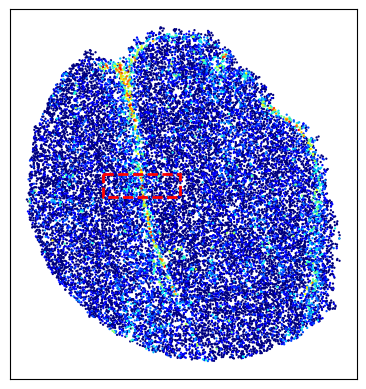

In [3]:
x_min, x_max, y_min, y_max = 1800, 2800, 3000, 3300

adata_raw = sc.read_h5ad(f'results/SlideseqV2/{data_name}_raw.h5ad')
adata_raw.obs['mask'] = ((adata_raw.obsm['spatial'][:, 0] >= x_min) & 
                         (adata_raw.obsm['spatial'][:, 0] <= x_max) & 
                         (adata_raw.obsm['spatial'][:, 1] >= y_min) & 
                         (adata_raw.obsm['spatial'][:, 1] <= y_max)).astype(str)
adata1 = adata_raw[adata_raw.obs['mask'] == 'True', :].copy()
sc.pp.log1p(adata1)

adata = sc.read_h5ad(f'results/SlideseqV2/{data_name}_DiffGSP.h5ad')
adata = adata[adata_raw.obs_names]
adata.obsm['spatial'] = adata_raw.obsm['spatial']
adata.obs['mask'] = ((adata.obsm['spatial'][:, 0] >= x_min) & 
                     (adata.obsm['spatial'][:, 0] <= x_max) & 
                     (adata.obsm['spatial'][:, 1] >= y_min) & 
                     (adata.obsm['spatial'][:, 1] <= y_max)).astype(str)
adata2 = adata[adata.obs['mask'] == 'True', :].copy()
sc.pp.log1p(adata2)

sc.pp.log1p(adata_raw)
fig, ax = plt.subplots()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.add_patch(plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, fill=False, color='red', linewidth=2, zorder=2, linestyle='--'))
sc.pl.spatial(adata_raw, color='Ptgds', spot_size=30, ax=ax, colorbar_loc=None, title='', save=f'SlideseqV2/{data_name}/gene_Ptgds_raw.pdf', cmap='jet')

16
16


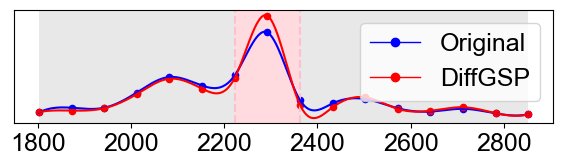

In [4]:
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D

def x_expression(adata, gene, dx=100):
    x_min = np.min(adata.obsm['spatial'][:, 0])
    x_max = np.max(adata.obsm['spatial'][:, 0])
    x_coords = np.arange(x_min, x_max + dx, dx)
    print(len(x_coords))
    y_coords = []
    for x in x_coords:
        mask = (adata.obsm['spatial'][:, 0] >= x) & (adata.obsm['spatial'][:, 0] < x + dx)
        y_coords.append(np.array(adata[mask, [gene]].X.sum()))
    y_coords = y_coords / np.sum(y_coords)
    return x_coords, y_coords

dx = 70
left = 6
x_coords1, y_coords1 = x_expression(adata1, gene='Ptgds', dx=dx)
x_coords2, y_coords2 = x_expression(adata2, gene='Ptgds', dx=dx)

f_raw = interp1d(x_coords1, y_coords1, kind='cubic')
f_DiffGSP = interp1d(x_coords2, y_coords2, kind='cubic')
x_new = np.linspace(min(x_coords1), max(x_coords1), 500)

plt.figure(figsize=(6, 2))
ax = plt.gca()  # 1750, 2850
x_ranges = [(x_coords1.min(), x_coords1[left], 'lightgray'), (x_coords1[left], x_coords1[left+2], 'lightpink'),
            (x_coords1[left+2], x_coords1.max(), 'lightgray')]
for x_start, x_end, color in x_ranges:
    ax.axvspan(x_start, x_end, facecolor=color, alpha=0.5, zorder=0)
plt.axvline(x=x_coords1[left], color='pink', linestyle='--')
plt.axvline(x=x_coords1[left+2], color='pink', linestyle='--')

plt.plot(x_new, f_raw(x_new), label='raw', color='blue')
plt.plot(x_new, f_DiffGSP(x_new), label='DiffGSP', color='red')
plt.scatter(x_coords1, y_coords1, marker='o', color='blue', s=20)
plt.scatter(x_coords2, y_coords2, marker='o', color='red', s=20)

custom_lines = [Line2D([0], [0], color='blue', lw=1, marker='o'),
               Line2D([0], [1], color='red', lw=1, marker='o')]
plt.legend(custom_lines, ['Original', 'DiffGSP'])
# ax.set_ylabel('gene expression')
# ax.tick_params(axis='x', labelbottom=False)
ax = plt.gca()
ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
plt.tight_layout()
# plt.show()
plt.savefig(f'figures/showSlideseqV2/{data_name}/distribution_Ptgds.pdf')

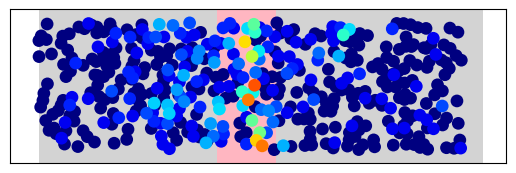

In [5]:
fig, ax1 = plt.subplots()
ax1.xaxis.set_visible(False)
ax1.yaxis.set_visible(False)
x_ranges = [(x_coords1.min(), x_coords1[left], 'lightgray'), (x_coords1[left], x_coords1[left+2], 'lightpink'),
            (x_coords1[left+2], x_coords1.max(), 'lightgray')]
for x_start, x_end, color in x_ranges:
    ax1.axvspan(x_start, x_end, facecolor=color, alpha=1, zorder=0)
sc.pl.spatial(adata1, color='Ptgds', spot_size=30, colorbar_loc=None, title='', ax=ax1, cmap='jet', save=f'SlideseqV2/{data_name}/gene_Ptgds_small_raw.pdf',
             vmin=0, vmax=7)

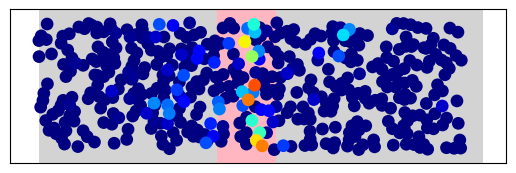

In [6]:
fig, ax2 = plt.subplots()
ax2.xaxis.set_visible(False)
ax2.yaxis.set_visible(False)
x_ranges = [(x_coords1.min(), x_coords1[left], 'lightgray'), (x_coords1[left], x_coords1[left+2], 'lightpink'),
            (x_coords1[left+2], x_coords1.max(), 'lightgray')]
for x_start, x_end, color in x_ranges:
    ax2.axvspan(x_start, x_end, facecolor=color, alpha=1, zorder=0)
sc.pl.spatial(adata2, color='Ptgds', spot_size=30, colorbar_loc=None, title='', ax=ax2, cmap='jet', save=f'SlideseqV2/{data_name}/gene_Ptgds_small_DiffGSP.pdf',
              vmin=1, vmax=7)

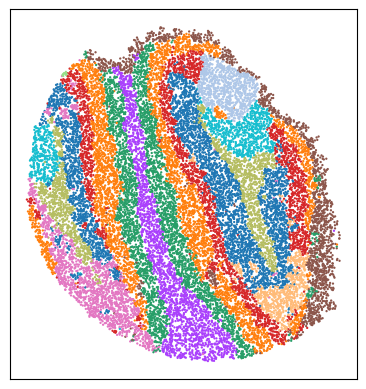

In [5]:
# STAGATE
plt.rcParams.update({'font.size': 12})
adata = sc.read_h5ad(f'results/SlideseqV2/{data_name}_DiffGSP.h5ad')
emb_DiffGSP = pd.read_csv(f'/home/sunshuli/project/STAGATE/STAGATE_results/Puck_200127_15_DiffGSP_emb.csv', index_col=0)
emb_DiffGSP = emb_DiffGSP.loc[adata.obs_names, :]
adata.obsm['STAGATE'] = emb_DiffGSP.values

sc.pp.log1p(adata)
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.leiden(adata, resolution=0.45)
fig, ax = plt.subplots()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
sc.pl.spatial(adata, color='leiden', spot_size=30, ax=ax,  title='', legend_loc=None,
              save=f'SlideseqV2/{data_name}/leiden_DiffGSP.pdf', cmap='jet')

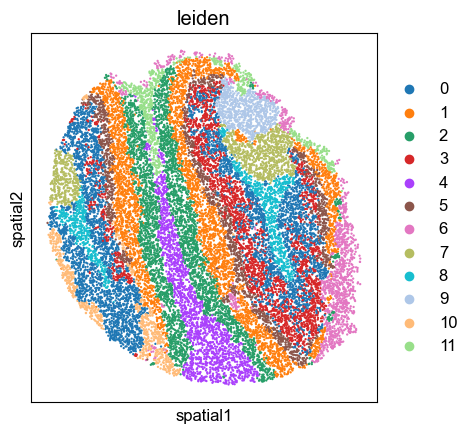

In [4]:
# STAGATE
adata_raw = sc.read_h5ad(f'results/SlideseqV2/{data_name}_raw.h5ad')
emb_raw = pd.read_csv(f'/home/sunshuli/project/STAGATE/STAGATE_results/Puck_200127_15_raw_emb.csv', index_col=0)
emb_raw = emb_raw.loc[adata_raw.obs_names, :]
adata_raw.obsm['STAGATE'] = emb_raw.values

sc.pp.log1p(adata_raw)
sc.pp.neighbors(adata_raw, use_rep='STAGATE')
sc.tl.leiden(adata_raw, resolution=0.38)
sc.pl.spatial(adata_raw, color='leiden', spot_size=30)

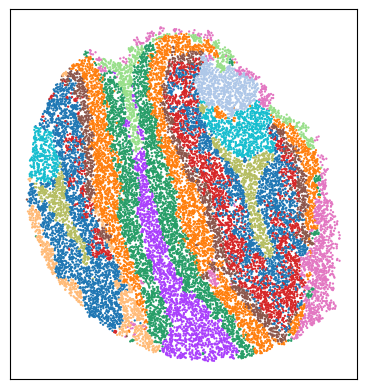

In [7]:
temp = adata_raw.uns['leiden_colors'][7]
adata_raw.uns['leiden_colors'][7] = adata_raw.uns['leiden_colors'][8]
adata_raw.uns['leiden_colors'][8] = temp
fig, ax = plt.subplots()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
sc.pl.spatial(adata_raw, color='leiden', spot_size=30, ax=ax, legend_loc=None, title='', 
              save=f'SlideseqV2/{data_name}/leiden_raw.pdf', cmap='jet')

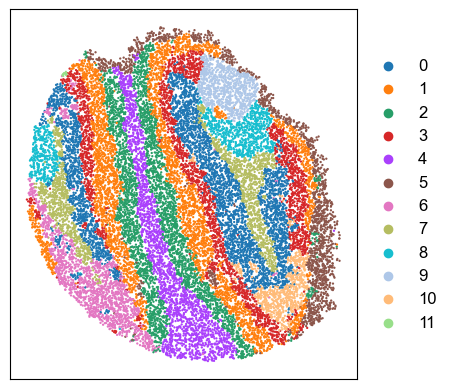

In [9]:
# STAGATE
adata = sc.read_h5ad(f'results/SlideseqV2/{data_name}_DiffGSP.h5ad')
emb_DiffGSP = pd.read_csv(f'/home/sunshuli/project/STAGATE/STAGATE_results/Puck_200127_15_DiffGSP_emb.csv', index_col=0)
emb_DiffGSP = emb_DiffGSP.loc[adata.obs_names, :]
adata.obsm['STAGATE'] = emb_DiffGSP.values

sc.pp.log1p(adata)
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.leiden(adata, resolution=0.45)
fig, ax = plt.subplots()
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
sc.pl.spatial(adata, color='leiden', spot_size=30, ax=ax,  title='', 
              save=f'SlideseqV2/{data_name}/leiden_DiffGSP.pdf', cmap='jet')

In [3]:
adata_raw = sc.read_h5ad(f'results/SlideseqV2/{data_name}_raw.h5ad').T[:100, :]
sc.pp.log1p(adata_raw)
sc.pp.neighbors(adata_raw)
sc.tl.leiden(adata_raw, resolution=2.5) # 0.8

adata = sc.read_h5ad(f'results/SlideseqV2/{data_name}_DiffGSP.h5ad').T[:100, :]
sc.pp.log1p(adata)

adata_raw, np.unique(adata_raw.obs['leiden'])

         Falling back to preprocessing with `sc.pp.pca` and default params.


(AnnData object with n_obs × n_vars = 100 × 20139
     obs: 'leiden'
     var: 'in_tissue'
     uns: 'log1p', 'neighbors', 'leiden'
     obsm: 'X_pca'
     varm: 'spatial'
     obsp: 'distances', 'connectivities',
 array(['0', '1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
       dtype=object))

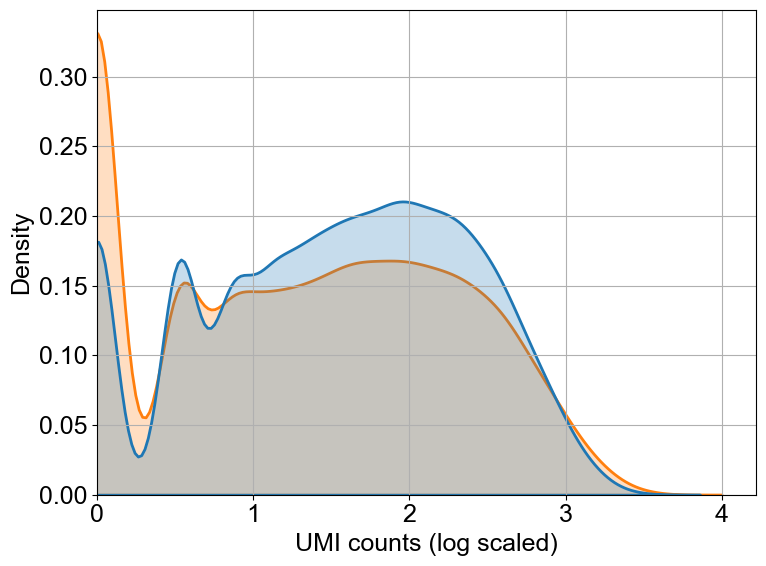

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 18})
# for ii in np.unique(adata_raw.obs['leiden']):
gene = (adata_raw.obs['leiden'] == '0')
plot_gene1 = np.log1p(np.sum(adata_raw[gene].X.toarray(), axis=0))
plot_gene2 = np.log1p(np.sum(adata[gene].X.toarray(), axis=0))
df = pd.DataFrame({'Raw': plot_gene1, 'DiffGSP': plot_gene2})

plt.figure(figsize=(8, 6))
sns.kdeplot(df, fill=True, linewidth=2, legend=False)
plt.xlabel('UMI counts (log scaled)')
plt.ylabel('Density')
plt.grid(True)
plt.xlim(0)
plt.tight_layout()
# plt.show()
plt.savefig(f'figures/showSlideseqV2/{data_name}/density_genes.pdf')

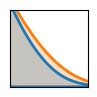

In [12]:
# 绘制局部放大图
fig, ax = plt.subplots(figsize=(1, 1))
sns.kdeplot(df, fill=True, linewidth=2, legend=False)
plt.xlim(3, 3.5)
plt.ylim(0, 0.05)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
# plt.show()
plt.savefig(f'figures/showSlideseqV2/{data_name}/density_genes1.pdf')

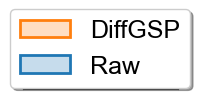

In [13]:
fig, ax = plt.subplots(figsize=(2, 1))
sns.kdeplot(df, fill=True, linewidth=2)
plt.xlim(3, 3.5)
plt.ylim(0, 0.05)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.legend(['DiffGSP', 'Raw'], loc='upper center', bbox_to_anchor=(0.5, 1.2), shadow=True, ncol=1)
# plt.show()
plt.savefig(f'figures/showSlideseqV2/{data_name}/density_genes_legend.pdf')

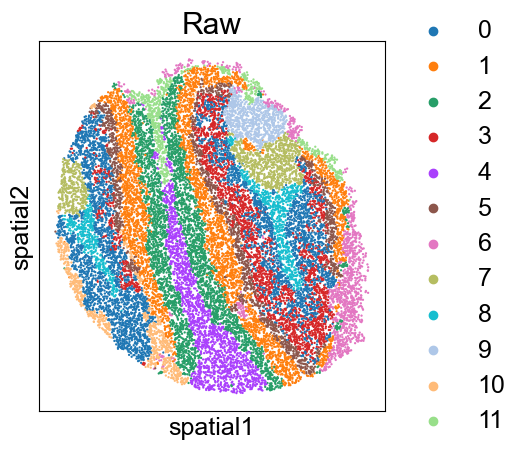

In [14]:
# STAGATE
adata_raw = sc.read_h5ad(f'results/SlideseqV2/{data_name}_raw.h5ad')
emb_raw = pd.read_csv(f'/home/sunshuli/project/STAGATE/STAGATE_results/Puck_200127_15_raw_emb.csv', index_col=0)
emb_raw = emb_raw.loc[adata_raw.obs_names, :]
adata_raw.obsm['STAGATE'] = emb_raw.values
sc.pp.log1p(adata_raw)
sc.pp.neighbors(adata_raw, use_rep='STAGATE')
sc.tl.leiden(adata_raw, resolution=0.38)
sc.pl.spatial(adata_raw, color='leiden', title='Raw', spot_size=30, show=False)

import matplotlib.pyplot as plt
for i in np.unique(adata_raw.obs['leiden']):
    adata_raw1 = adata_raw.copy()
    adata_raw1.uns['leiden_colors'] = ['#D3D3D3'] * len(np.unique(adata_raw.obs['leiden']))
    adata_raw1.uns['leiden_colors'][int(i)] = adata_raw.uns['leiden_colors'][int(i)]
    fig, ax = plt.subplots()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    sc.pl.spatial(adata_raw1, color='leiden', spot_size=30, groups=i, legend_loc=None, ax=ax, title='', show=False,
                 save=f'SlideseqV2/{data_name}/raw_{i}.pdf')

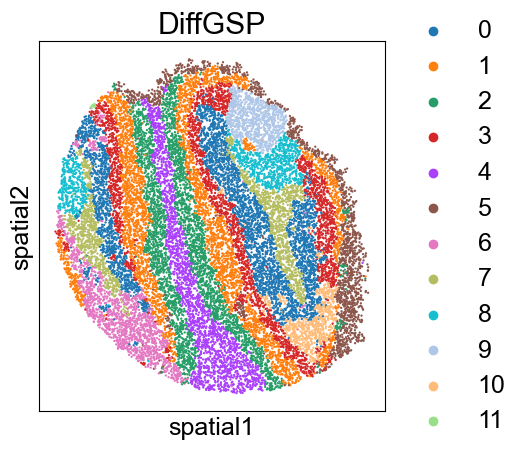

In [15]:
adata = sc.read_h5ad(f'results/SlideseqV2/{data_name}_DiffGSP.h5ad')
emb_DiffGSP = pd.read_csv(f'/home/sunshuli/project/STAGATE/STAGATE_results/Puck_200127_15_DiffGSP_emb.csv', index_col=0)
emb_DiffGSP = emb_DiffGSP.loc[adata.obs_names, :]
adata.obsm['STAGATE'] = emb_DiffGSP.values
sc.pp.log1p(adata)
sc.pp.neighbors(adata, use_rep='STAGATE')
sc.tl.leiden(adata, resolution=0.45)
sc.pl.spatial(adata, color='leiden', title='DiffGSP', spot_size=30, show=False)

for i in np.unique(adata.obs['leiden']):
    adata1 = adata.copy()
    adata1.uns['leiden_colors'] = ['#D3D3D3'] * len(np.unique(adata.obs['leiden']))
    adata1.uns['leiden_colors'][int(i)] = adata.uns['leiden_colors'][int(i)]
    fig, ax = plt.subplots()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    sc.pl.spatial(adata1, color='leiden', spot_size=30, groups=i, legend_loc=None, ax=ax, title='', show=False,
                 save=f'SlideseqV2/{data_name}/DiffGSP_{i}.pdf')